In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import torch
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
from torch import optim
from torch import nn
import time
from collections import defaultdict
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.metrics import f1_score
from torchvision.models import resnet50, efficientnet_b6, vgg19_bn, resnet18, vgg11_bn
from torch.utils.data import RandomSampler, WeightedRandomSampler
from torchvision.utils import draw_bounding_boxes
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
#!unzip /content/EyesTrain.zip -d /content

# Работа с данными

In [7]:
path_neg = os.listdir("/content/SplitTrain/neg")
path_pos = os.listdir("/content/SplitTrain/pos")

In [8]:
path_neg = ['/content/SplitTrain/neg/' + path_neg[i] for i in range(len(path_neg))]
path_pos = ['/content/SplitTrain/pos/' + path_pos[i] for i in range(len(path_pos))]
X = np.concatenate([path_neg, path_pos])

In [9]:
y = np.array([0] * len(path_neg) + [1] * len(path_pos))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2, shuffle=True)

In [11]:
class ImageFolderEye(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = Image.open(self.x[idx])
        img = self.transform(img)
        return img, self.y[idx]

In [12]:
train_transforms = transforms.Compose([
    transforms.Resize((24, 24)),
    torchvision.transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(0.6117, 0.1954)
])

validation_transforms = transforms.Compose([
    transforms.Resize((24, 24)),
    torchvision.transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(0.6117, 0.1954)
])

In [13]:
batch_size = 128
train_dataset = ImageFolderEye(x = X_train, y = y_train, transform = train_transforms)

val_dataset = ImageFolderEye(x = X_test, y = y_test, transform = validation_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle = True
)
valid_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle = False
)

In [14]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 24, 24]), torch.Size([128]))

# Обучение моделей

In [15]:
def compute_eer(labels, scores):
    """Compute the Equal Error Rate (EER) from the predictions and scores.
    Args:
        labels (list[int]): values indicating whether the ground truth
            value is positive (1) or negative (0).
        scores (list[float]): the confidence of the prediction that the
            given sample is a positive.
    Return:
        (float, thresh): the Equal Error Rate and the corresponding threshold"""

    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)
    return eer, thresh 

In [16]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''

    plt.figure(figsize=(20, 15))

    plt.subplot(2,2,1)
    plt.title('Loss')
    plt.plot(history['loss']['train'], label='train', lw=3)
    plt.plot(history['loss']['val'], label='val', lw=3)
    plt.xlabel('Эпоха')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title('Accuracy')
    plt.plot(history['acc']['train'], label='train', lw=3)
    plt.plot(history['acc']['val'], label='val', lw=3)
    plt.xlabel('Эпоха')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title('F1_score')
    plt.plot(history['f1']['train'], label='train', lw=3)
    plt.plot(history['f1']['val'], label='val', lw=3)
    plt.xlabel('Эпоха')
    plt.legend()

    plt.subplot(2,2,4)
    plt.title('EER')
    plt.plot(history['eer']['train'], label='train', lw=3)
    plt.plot(history['eer']['val'], label='val', lw=3)
    plt.xlabel('Эпоха')
    plt.legend()

    plt.show()

In [17]:
def train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs,
    device,
    history,
    normalize = False,
    alpha_norm = 0
):
    """
    # Обучение модели
    """
    start_time = time.time()

    best_f1 = 0

    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0
        val_acc = 0
        train_acc = 0

        general_mean = 0
        general_std = 0

        train_targets = []
        train_output = []
        train_scores = []

        test_targets = []
        test_output = []
        test_scores = []

        train_size, val_size = 0, 0

        model.train()  # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_loader, total=len(train_loader)):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            if normalize == True:
              mean = X_batch.mean()
              std = X_batch.std()
              X_batch = (X_batch - mean) / std
              general_mean = alpha_norm * mean + (1 - alpha_norm) * general_mean
              general_std = alpha_norm * std + (1 - alpha_norm) * general_std

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, axis=1).detach()

            train_scores.append(logits.detach().cpu().numpy()[:, 1])
            train_output.append(y_pred.cpu().numpy())
            train_targets.append(y_batch.cpu().numpy())

            train_size += len(y_batch)
            train_acc += (y_batch == y_pred).sum()

        # Подсчитываем лоссы и точность, сохраняем в "историю"
        train_loss = train_loss.cpu().numpy() / train_size
        train_f1 = f1_score(y_true=np.concatenate(train_targets), y_pred=np.concatenate(train_output),
                            average='binary')
        train_acc = train_acc.cpu().numpy() / train_size
        train_eer = compute_eer(np.concatenate(train_targets), np.concatenate(train_scores))[0]


        history['f1']['train'].append(train_f1)
        history['acc']['train'].append(train_acc)
        history['loss']['train'].append(train_loss)
        history['eer']['train'].append(train_eer)

        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()

        # Полный проход по валидации
        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, total=len(val_loader)):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                if normalize == True:
                  X_batch = (X_batch - general_mean) / general_std
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_loss += loss.detach() * len(y_batch)
                y_pred = torch.argmax(logits, axis=1).detach()
                val_size += len(y_batch)
                val_acc += (y_batch == y_pred).sum()

                test_scores.append(logits.detach().cpu().numpy()[:, 1])

                test_output.append(y_pred.cpu().numpy())
                test_targets.append(y_batch.cpu().numpy())

        # Подсчитываем лоссы и сохраняем в "историю"
        val_loss = val_loss.cpu().numpy() / val_size
        val_f1 = f1_score(y_true=np.concatenate(test_targets), y_pred=np.concatenate(test_output),
                          average='binary')
        val_acc = val_acc.cpu().numpy() / val_size
        val_eer = compute_eer(np.concatenate(test_targets), np.concatenate(test_scores))[0]


        history['loss']['val'].append(val_loss)
        history['f1']['val'].append(val_f1)
        history['acc']['val'].append(val_acc)
        history['eer']['val'].append(val_eer)


        #if val_f1_macro > best_f1:
        #    torch.save(model.state_dict(), path)
        #    best_f1 = val_f1_macro
        clear_output()
        # Печатаем результаты после каждой эпохи
        print("Эпоха {} из {}, время {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time
        ))
        print("  loss на обучении (на итерации): \t{:.6f}".format(train_loss))
        print("  loss на валидации (на итерации): \t{:.6f}".format(val_loss))
        print("  accuracy на обучении: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  accuracy на валидации: \t\t\t{:.2f} %".format(val_acc * 100))
        print("  f1_score на обучении: \t\t\t{:.2f} %".format(train_f1 * 100))
        print("  f1_score на валидации: \t\t\t{:.2f} %".format(val_f1 * 100))
        print("  eer на обучении: \t\t\t{:.2f} %".format(train_eer))
        print("  eer на валидации: \t\t\t{:.2f} %".format(val_eer))

        plot_learning_curves(history)

Попробуем обучить самую тривиальную модель, который состоит только из FC слоев:

In [19]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=24*24, num_classes=2, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512, 0.5),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256, 0.5),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

Эпоха 20 из 20, время 70.351s
  loss на обучении (на итерации): 	0.257210
  loss на валидации (на итерации): 	0.250354
  accuracy на обучении: 			88.73 %
  accuracy на валидации: 			90.10 %
  f1_score на обучении: 			88.93 %
  f1_score на валидации: 			90.49 %
  eer на обучении: 			0.11 %
  eer на валидации: 			0.10 %


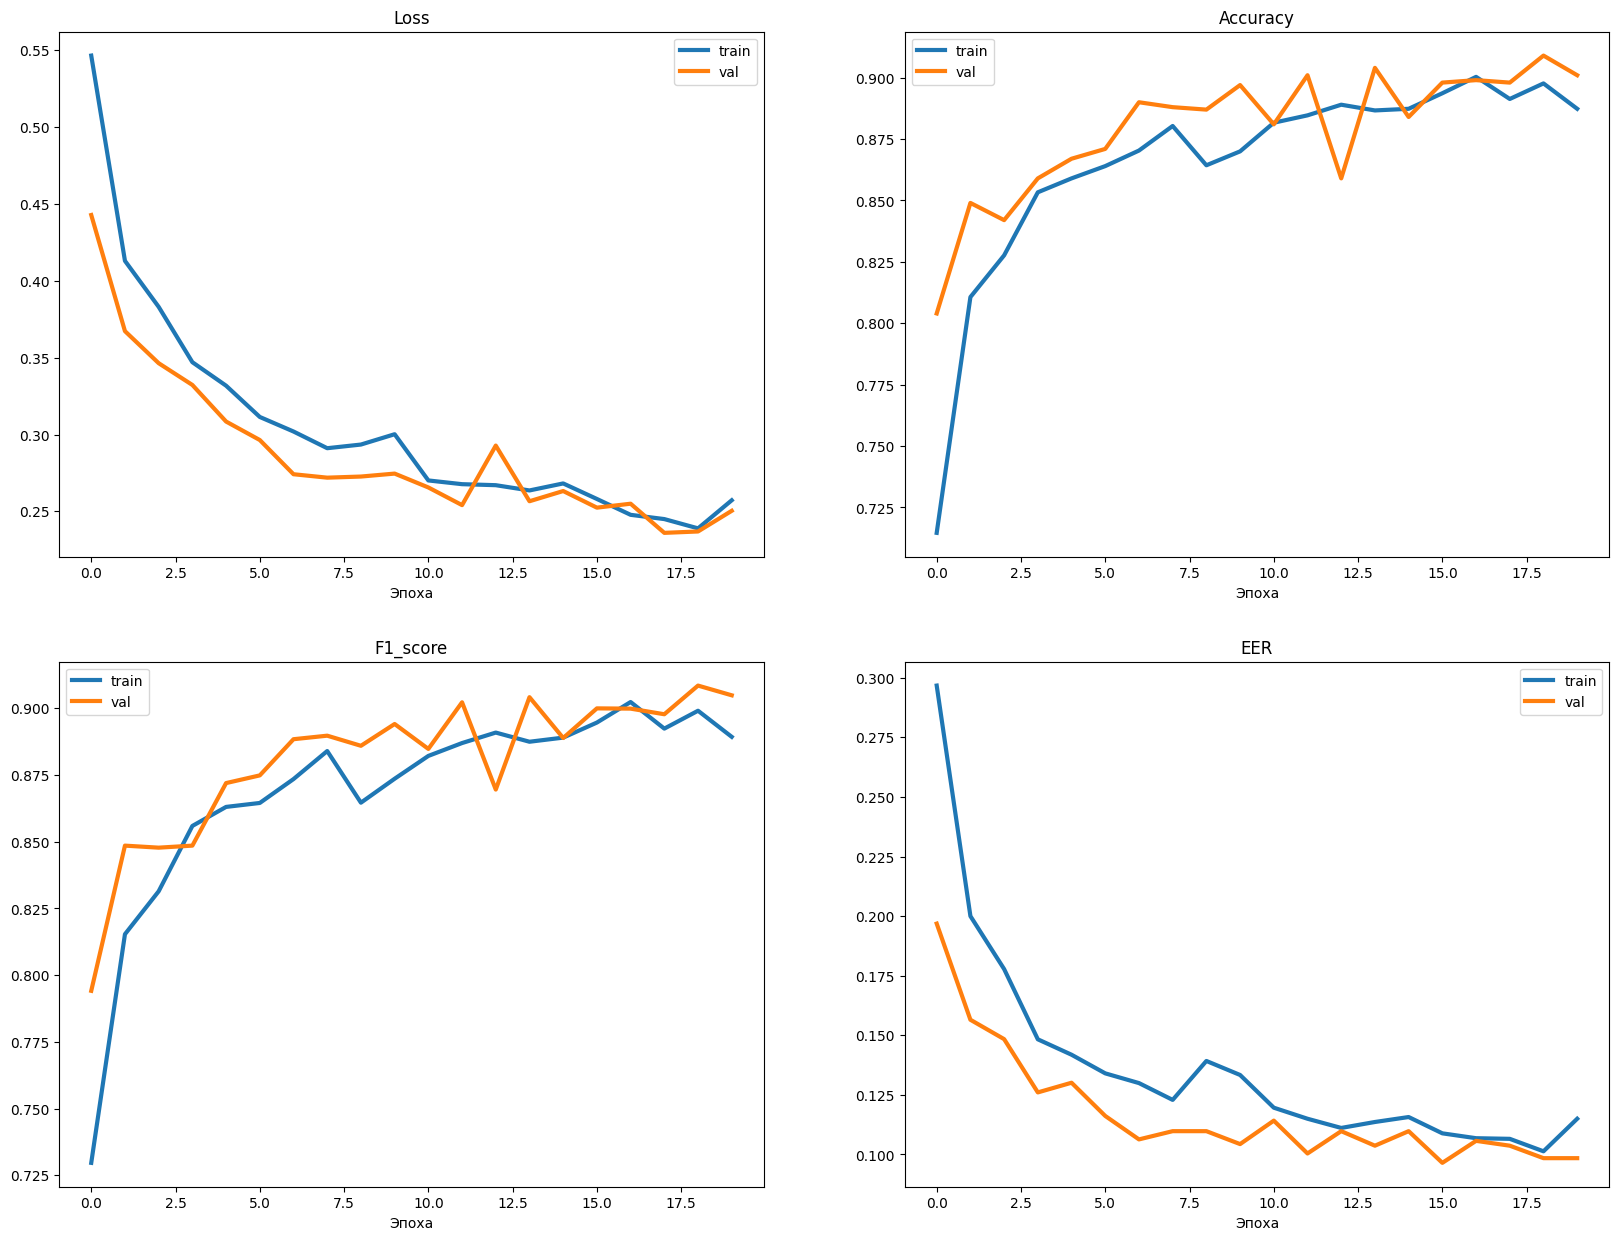

In [20]:
model = TinyNeuralNetwork(input_shape = 24*24, num_classes = 2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
history = defaultdict(lambda: defaultdict(list))

n_epochs = 20

train(
    model,
    loss_func,
    opt,
    train_loader,
    valid_loader,
    n_epochs,
    device,
    history,
    False,
    0.5
)

Как мы видим, результаты в целом неплохие, но можно и лучше. 

Попробуем в этот раз сделал CNN с двумя convolutions:

In [21]:
class SimpleConvNetwork(nn.Module):
    def __init__(self, input_shape=24*24, num_classes=2, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(3, 3)), # size = (22 * 22 * 20)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # (11 * 11 * 20)

            nn.Conv2d(in_channels = 20, out_channels = 10, kernel_size = (2, 2)), # size = (10 * 10 * 10)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # size = (5 * 5 * 10)

            nn.Flatten(),
            nn.Linear(250, 128),
            nn.BatchNorm1d(128, 0.7),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64, 0.7),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

Эпоха 20 из 20, время 72.226s
  loss на обучении (на итерации): 	0.139677
  loss на валидации (на итерации): 	0.128275
  accuracy на обучении: 			94.53 %
  accuracy на валидации: 			94.60 %
  f1_score на обучении: 			94.62 %
  f1_score на валидации: 			94.79 %
  eer на обучении: 			0.05 %
  eer на валидации: 			0.05 %


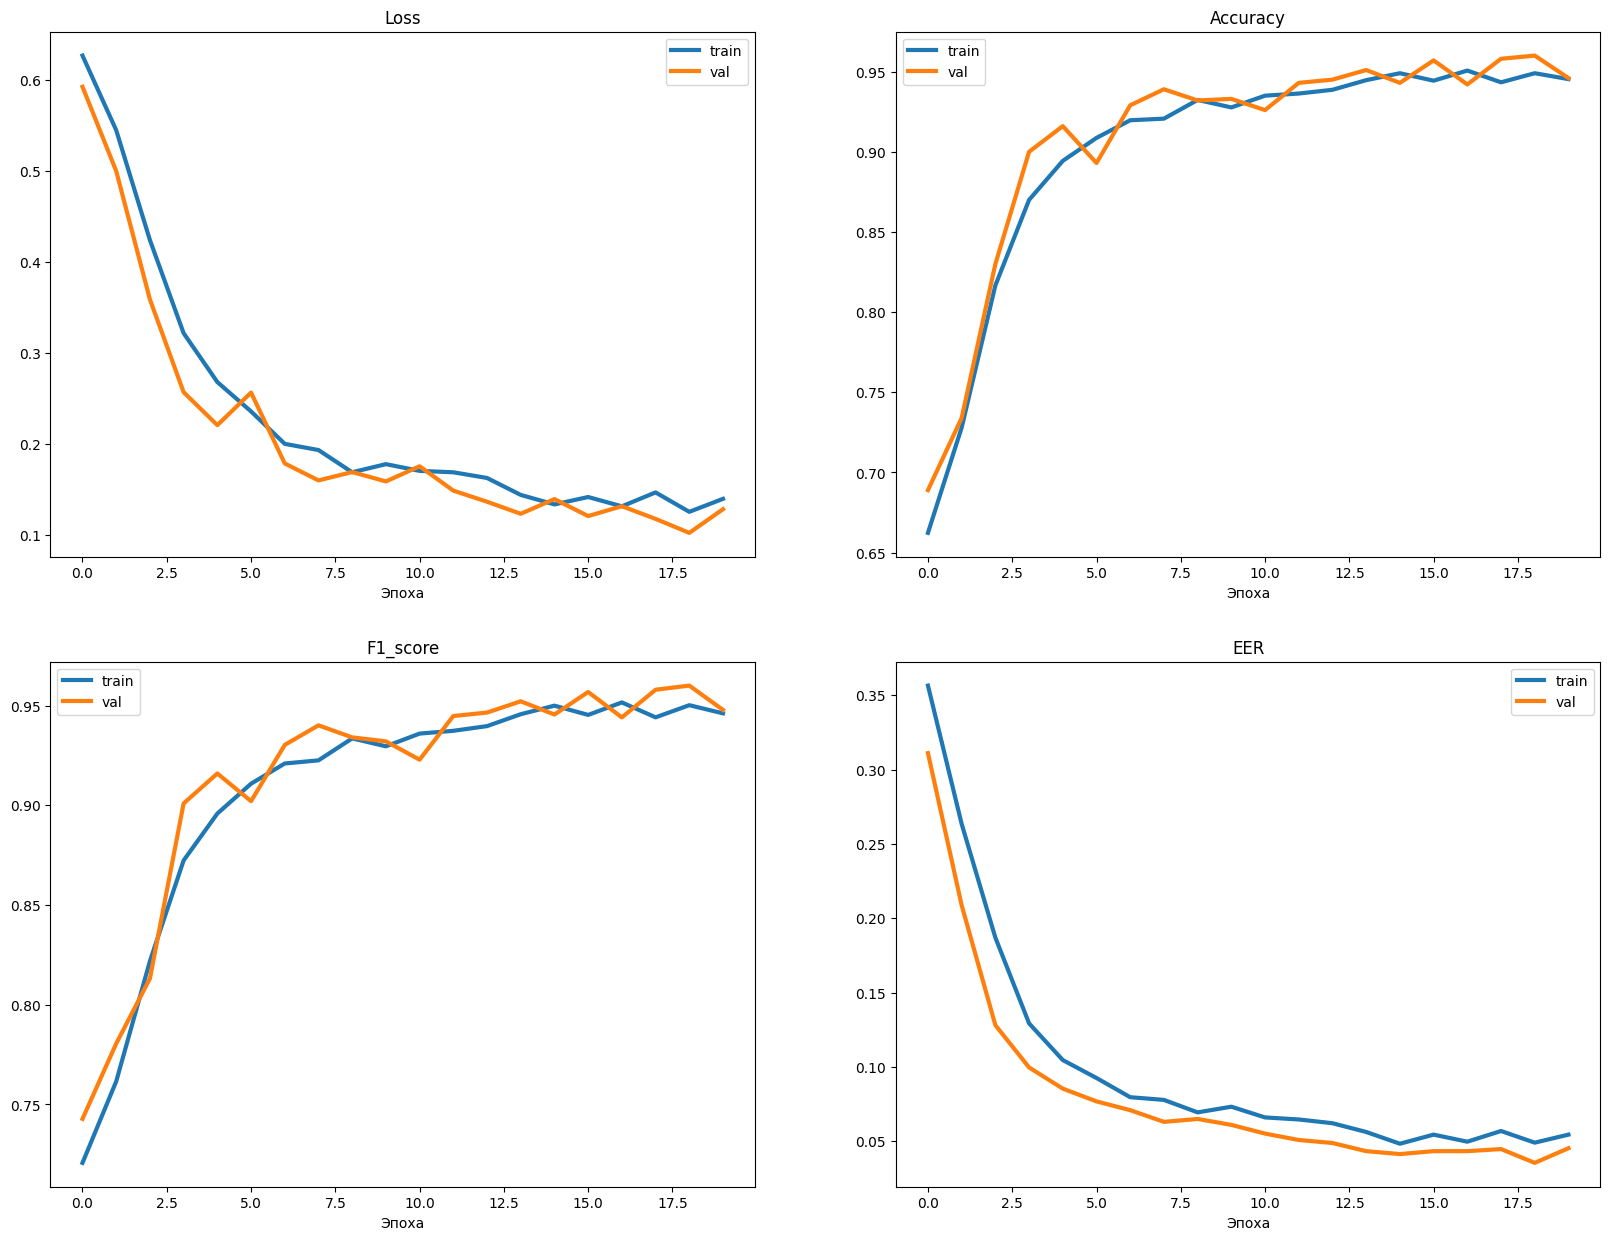

In [22]:
model = SimpleConvNetwork(input_shape = (24, 24), num_classes = 2).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
history = defaultdict(lambda: defaultdict(list))

n_epochs = 20

train(
    model,
    loss_func,
    opt,
    train_loader,
    valid_loader,
    n_epochs,
    device,
    history,
    False,
    0.5
)

Результат стал гораздо лучше, что в целом неудивительно. Но все же хочется получить EER на валидации меньше 0.05. Попробуем добавить BatchNorm:

In [23]:
class BatchedConvNetwork(nn.Module):
    def __init__(self, input_shape=24*24, num_classes=2, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3)), # size = (22 * 22 * 20)
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # (11 * 11 * 10)


            nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = (2, 2)), # size = (10 * 10 * 20)
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # size = (5 * 5 * 20)


            nn.Flatten(),
            nn.Linear(500, 256),
            nn.BatchNorm1d(256, 0.7),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64, 0.7),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

Эпоха 20 из 20, время 67.147s
  loss на обучении (на итерации): 	0.089024
  loss на валидации (на итерации): 	0.099959
  accuracy на обучении: 			96.67 %
  accuracy на валидации: 			96.20 %
  f1_score на обучении: 			96.74 %
  f1_score на валидации: 			96.25 %
  eer на обучении: 			0.03 %
  eer на валидации: 			0.04 %


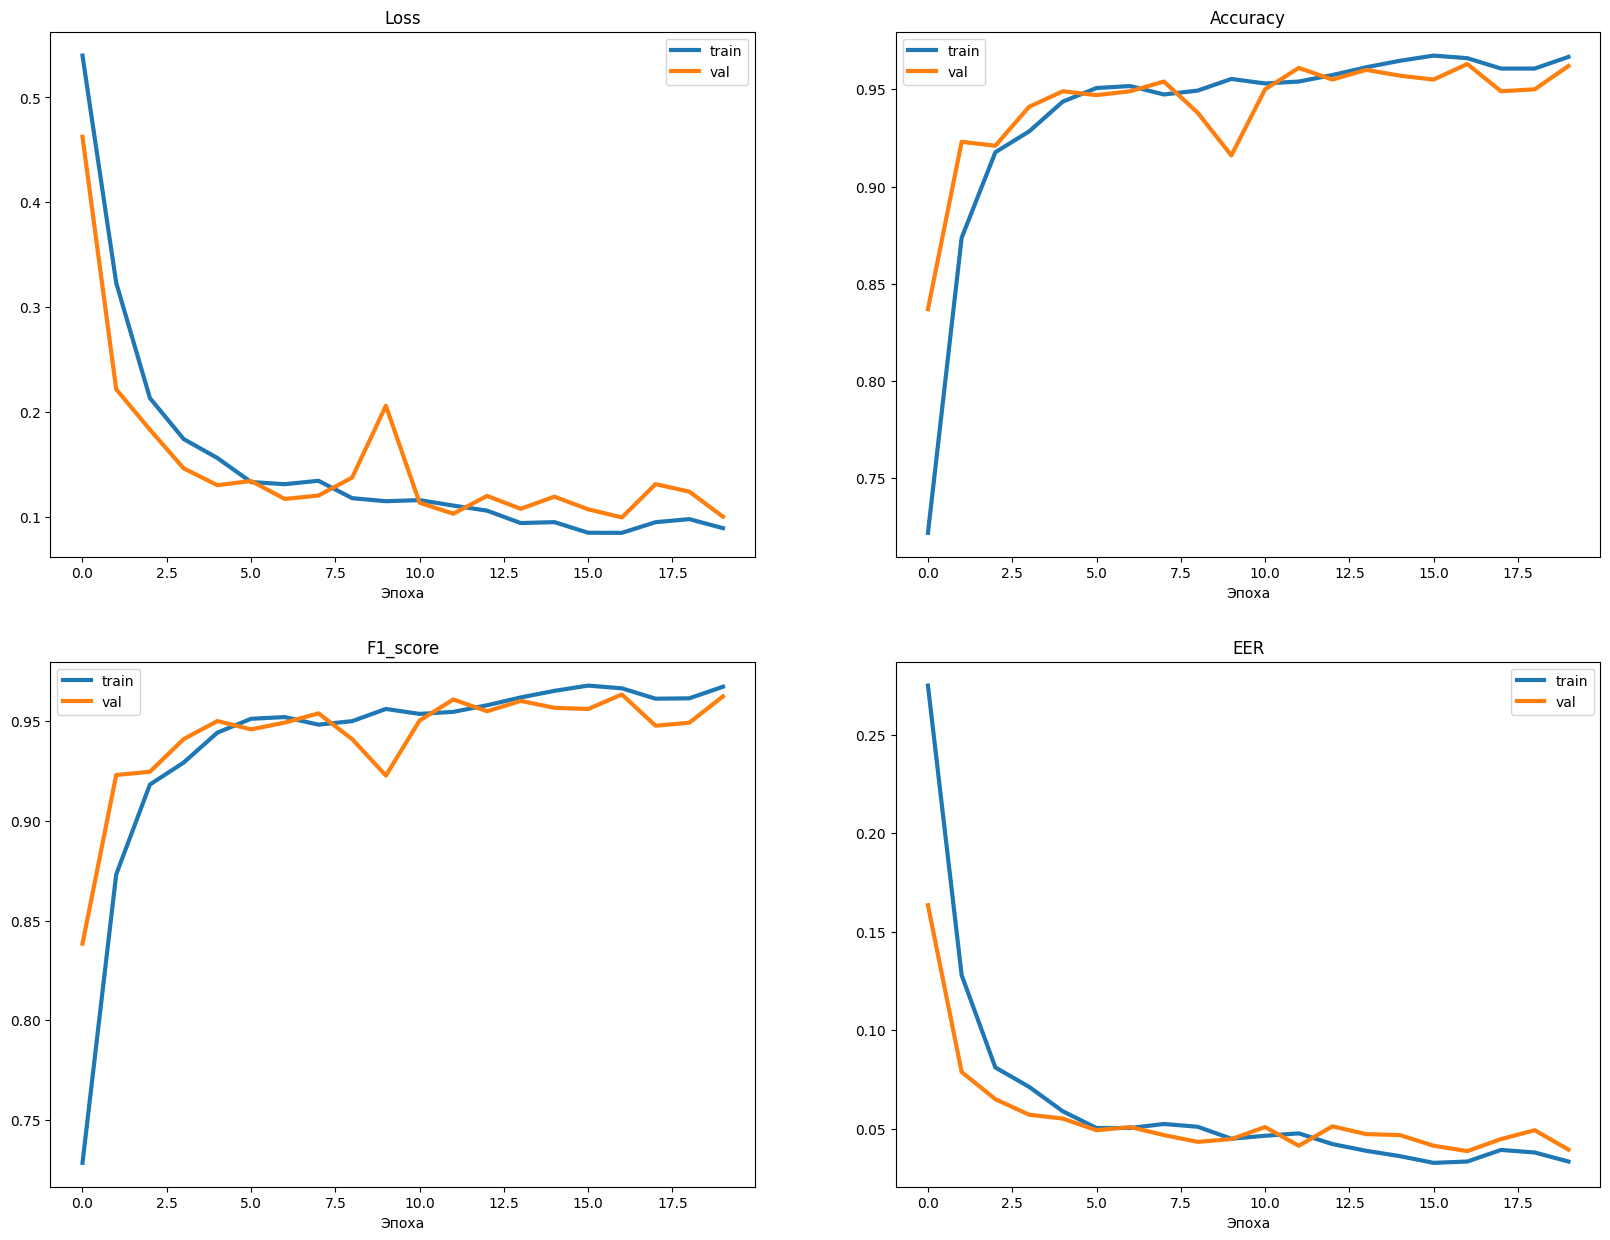

In [24]:
model = BatchedConvNetwork(input_shape = (24, 24), num_classes = 2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
history = defaultdict(lambda: defaultdict(list))

n_epochs = 20

train(
    model,
    loss_func,
    opt,
    train_loader,
    valid_loader,
    n_epochs,
    device,
    history,
    False,
    0.5
)

Получили очень хороший результат, но давайте попробуем добавить еще один CNN и padding:

In [25]:
class BatchedConvNetworkPad(nn.Module):
    def __init__(self, input_shape=24*24, num_classes=2, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(3, 3), padding=1), # size = (24 * 24 * 20)
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # (12 * 12 * 20)

            nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size = (2, 2)), # size = (11 * 11 * 40)
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # size = (5 * 5 * 40)

            nn.Conv2d(in_channels = 40, out_channels = 60, kernel_size = (2, 2)), # size = (4 * 4 * 60)
            nn.BatchNorm2d(60),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # (2 * 2 * 60)

            nn.Flatten(),
            nn.Linear(240, 128),
            nn.BatchNorm1d(128, 0.7),
            nn.ReLU(),
            nn.Dropout(0.55),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64, 0.7),
            nn.ReLU(),
            nn.Dropout(0.55),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16, 0.7),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(16, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

Эпоха 20 из 20, время 68.978s
  loss на обучении (на итерации): 	0.108811
  loss на валидации (на итерации): 	0.111594
  accuracy на обучении: 			96.60 %
  accuracy на валидации: 			95.60 %
  f1_score на обучении: 			96.67 %
  f1_score на валидации: 			95.77 %
  eer на обучении: 			0.03 %
  eer на валидации: 			0.03 %


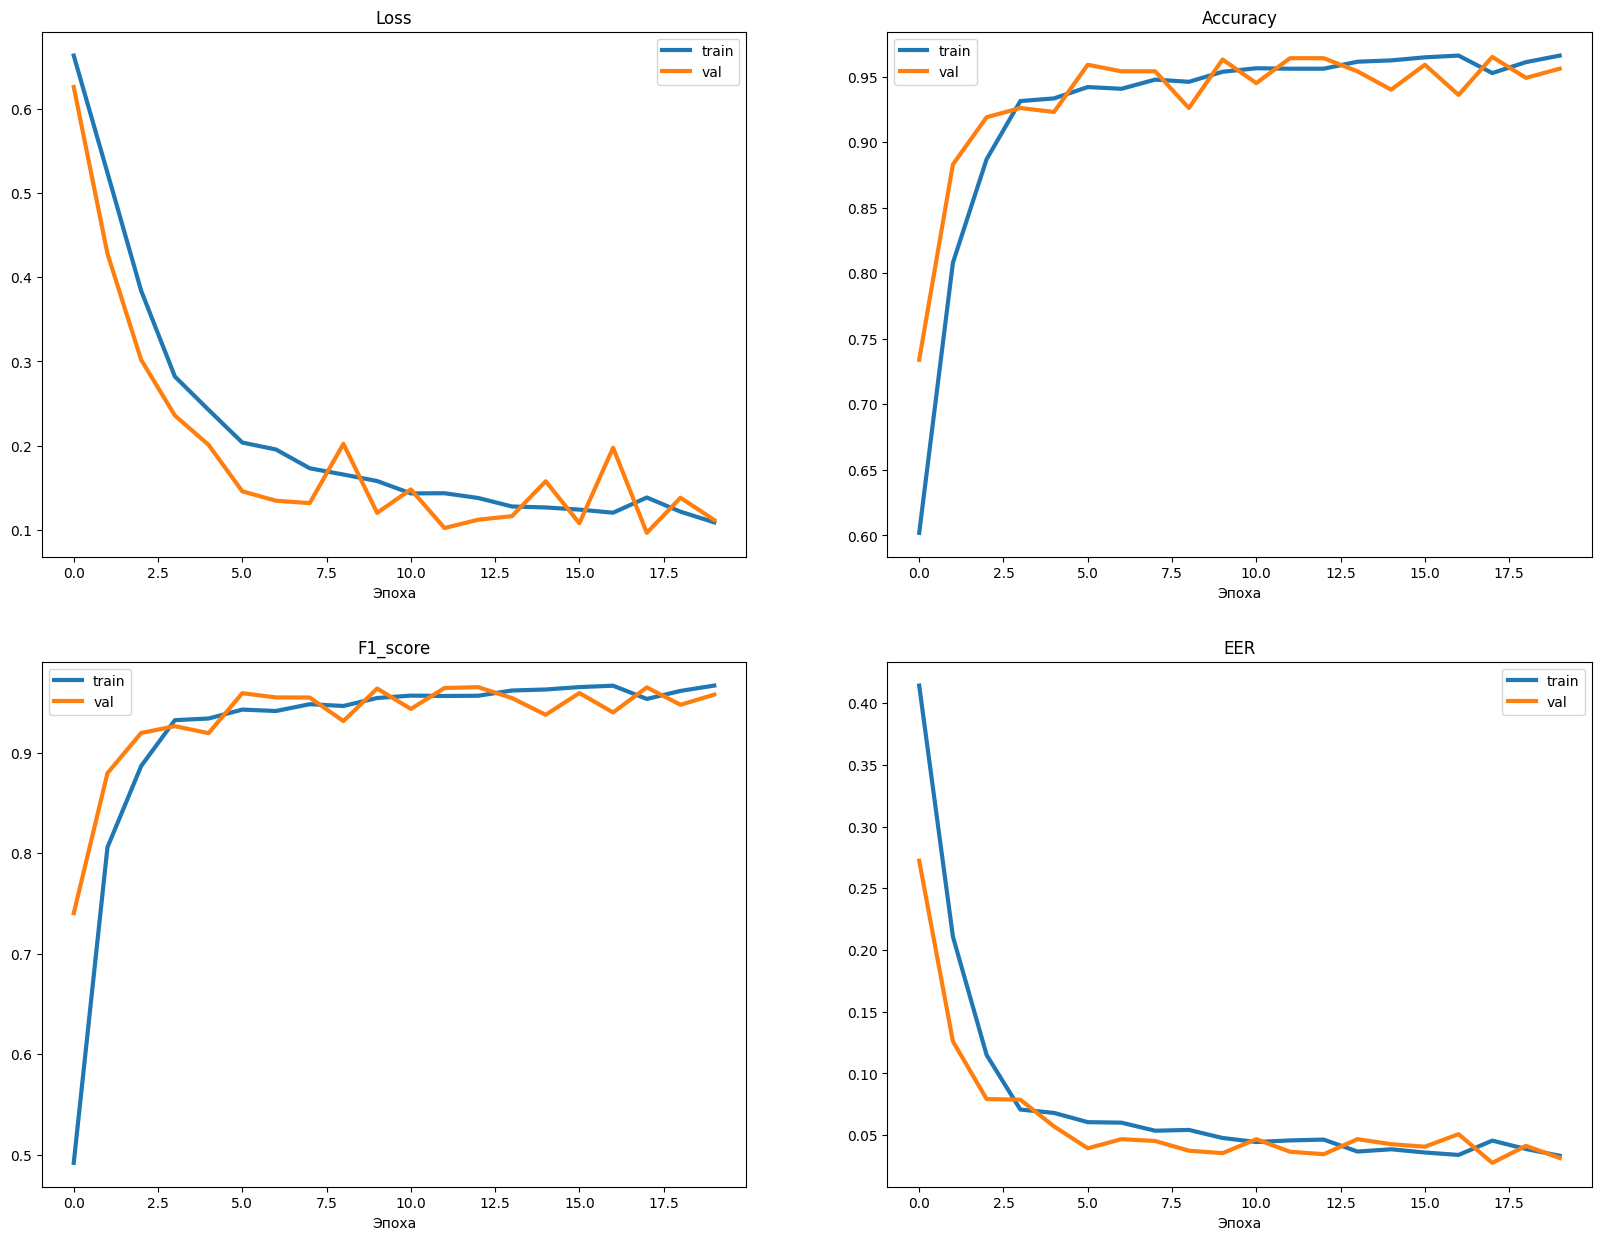

In [26]:
model = BatchedConvNetworkPad(input_shape = (24, 24), num_classes = 2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
history = defaultdict(lambda: defaultdict(list))

n_epochs = 20

train(
    model,
    loss_func,
    opt,
    train_loader,
    valid_loader,
    n_epochs,
    device,
    history,
    False,
    0.5
)

Получили в целом очень хороший результат. Сохраним веса последней модели.

In [27]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save("/content/optim_model.pt") # Save

In [28]:
torch.save(model.state_dict(), "/content/optim_model_weights.pt")